<a href="https://colab.research.google.com/github/asif-siddiqui-ds/Sentiment_Analysis/blob/main/Topic_Modeling_with_Llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Llama2** 🦙
*Create easily interpretable topics with BERTopic and Llama 2*
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/35441954-4405-465c-97f7-a57ee91315b8" width="750"/>
</div>


We will explore how we can use Llama2 for Topic Modeling without the need to pass every single document to the model. Instead, we are going to leverage BERTopic, a modular topic modeling technique that can use any LLM for fine-tuning topic representations.

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

However, with the rise of LLMs like **Llama 2**, we can do much better than a bunch of independent words per topic. It is computally not feasible to pass all documents to Llama 2 directly and have it analyze them. We can employ vector databases for search but we are not entirely search which topics to search for.

Instead, we will leverage the clusters and topics that were created by BERTopic and have Llama 2 fine-tune and distill that information into something more accurate.

This is the best of both worlds, the topic creation of BERTopic together with the topic representation of Llama 2.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>

Now that this intro is out of the way, let's start the hands-on tutorial!

---
        
💡 **NOTE**: We will want to use a GPU to run both Llama2 as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [2]:
import pandas as pd
file_id = '1f23jhxl_Xv92Hzub3sBpWfA9SNv0vutb'
url = 'https://drive.google.com/uc?id={}'.format(file_id)
df = pd.read_excel(url)

In [ ]:
df = df.dropna()

In [3]:
df = df[df.ParticipantResponse != 'nan']

In [4]:
df['ParticipantResponse'] = df['ParticipantResponse'].astype(str).str.lower()

In [5]:
df.loc[df['QuestionType'] == "User Comment"].QuestionText.unique()

array(['Do you have any recommendations or suggestions about the Course that could improve your learning experience at AUE?'],
      dtype=object)

In [6]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

In [7]:
df['ParticipantResponse'] = df['ParticipantResponse'].apply(clean)

In [8]:
rating_df = df[df['QuestionType']=='Rating']

In [9]:
reviews_df = df[df['QuestionType']=='User Comment']

In [10]:
reviews_df['ParticipantResponse'] = df['ParticipantResponse'].str.replace(r'^(no,? )', '', regex=True)

<ipython-input-10-6ea0e4614105>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['ParticipantResponse'] = df['ParticipantResponse'].str.replace(r'^(no,? )', '', regex=True)


In [ ]:
df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,disagree
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,strongly disagree
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,strongly disagree
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,strongly disagree
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,strongly disagree


In [36]:
feedbacks = reviews_df[(reviews_df['ParticipantResponse'] != ' ') & (reviews_df['ParticipantResponse'].astype(str).apply(lambda x: len(x))>20)
                      & (reviews_df['ParticipantResponse'].astype(str).apply(lambda x: len(x))<200)]['ParticipantResponse'].tolist()

In [37]:
len(feedbacks)

830

In [ ]:
feedbacks

In [35]:
len('Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:')

139

To give you an idea, an abstract looks like the following:

# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [12]:
!pip install huggingface_hub
!pip install transformers
!pip install accelerate

In [13]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-13b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [14]:
from torch import cuda

model_id = 'meta-llama/Llama-2-13b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [15]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [16]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [17]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

In [40]:
prompt = f"Please analyze the following student feedback data and provide the top 5 common themes mentioned by students.\nFeedback Data:\n {feedbacks[100:150]} \nplease make sure you exclude this prompt from the output and only give lables for 5 common themese"

In [ ]:
# input_text = prompt + "\n".join(feedbacks[20:40])

In [ ]:
# input_text

In [41]:
res = generator(prompt)

In [42]:
res[0]['generated_text']

'Please analyze the following student feedback data and provide the top 5 common themes mentioned by students.\nFeedback Data:\n [\'recommendations the course was very well designed\', \'the psychology course was an interesting course however some chapters were a bit more advanced for university students especially undergrad students \', \'it was a wonderful course\', \'the professor is amazing and the explaining skills is best\', \'assignments weightings should be related to the assignment type given \', \'i would ve loved to learn different materials in philosophy\', \'please let the professor teach more courses\', \'doctor is highly skilled to teach us in a clear way\', \'everything was so clear and we learned new thing from the dr\', \'i want to thank you ms karoline because ur teaching is very clear and i understand from your teaching\', \'excellent course content suggest all student to take this course for understanding politics to be added to their knowledge\', \'all resources a

In [ ]:
# # prompt = f"I have a list of following student feedbacks: {feedbacks[:100]} \nGenerate the top 5 common themes or topics frequently mentioned by students in their feedbacks."
# # prompt = f"Extract insights from the following student feedbacks:\n {feedbacks[:100]} \n2. [Student Feedback 2]\n3. [Student Feedback 3]\n4. [Student Feedback 4]\n5. [Student Feedback 5]\n\nIdentify common themes or issues mentioned in these feedbacks."
# prompt = """
# Please analyze the following student feedback data and provide the top 5 common themes or topics with some keywords, mentioned by students. Exclude this prompt from the output.

# Feedback Data:
# 'the instructor should solve more',
# 'beneficial course and valuable material',
# 'everything was fine but i did not understand the instructor most of the time',
# 'recommendations a challenging yet enjoyable and interactive course ',
# 'i loved the accounting because of the dr',
# 'the dr is amazing he is knowledgable fun and friendly he knows his course well and always answers questions ',
# """


# # Combine the prompt and feedback data
# input_text = prompt.join(feedbacks[:20])

# # Now, you can use 'input_text' as the input to the Llama 2 model to extract the desired output.

# # prompt = f"I have a list of following student feedbacks and I would like to get the top 5 common themes or topics that are frequently mention by the studends in their feedbacks: {feedbacks[:10]} "
# # input_ids = tokenizer.encode(input_text, return_tensors="pt")
# res = generator(input_text)

In [ ]:
res[0]['generated_text']

"the instructor should solve more\nPlease analyze the following student feedback data and provide the top 5 common themes or topics with some keywords, mentioned by students. Exclude this prompt from the output.\n\nFeedback Data:\n'the instructor should solve more',\n'beneficial course and valuable material',\n'everything was fine but i did not understand the instructor most of the time',\n'recommendations a challenging yet enjoyable and interactive course ',\n'i loved the accounting because of the dr',\n'the dr is amazing he is knowledgable fun and friendly he knows his course well and always answers questions ',\nbeneficial course and valuable material\nPlease analyze the following student feedback data and provide the top 5 common themes or topics with some keywords, mentioned by students. Exclude this prompt from the output.\n\nFeedback Data:\n'the instructor should solve more',\n'beneficial course and valuable material',\n'everything was fine but i did not understand the instructo

## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [ ]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?

Sure! Imagine you have a big box of crayons. Each crayon represents a different color, like red, blue, green, and so on. Now, imagine that instead of having a whole box of crayons, you only have four crayons: red, blue, green, and yellow. These four crayons are like the numbers 0, 1, 2, and 3 in binary.

When you want to draw a picture, you can use any combination of these four crayons to make different colors. For example, if you use red and blue together, you get purple! If you use all four crayons at once, you get brown.

But here's the thing: sometimes, you might want to draw a picture with more than just four colors. Maybe you want to draw a picture with pink or orange or gray. But if you only have four crayons, you can't make those colors because they don't exist in your box of crayons.

That's where 4-bit quantization comes in. It's like taking your box of crayons and dividing it into smaller parts. Instead of h

Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

Next, let's see how we can use this template to optimize Llama 2 for topic modeling.

### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(feedbacks, show_progress_bar=True)

Batches:   0%|          | 0/5277 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(feedbacks, embeddings)


2023-10-02 19:30:56,171 - BERTopic - Reduced dimensionality
2023-10-02 19:31:31,355 - BERTopic - Clustered reduced embeddings
100%|██████████| 41/41 [03:40<00:00,  5.38s/it]


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,12545,-1_strongly_agree_thank_you,"[strongly, agree, thank, you, no, great, comme...","[agree, strongly, right, totally, commendable,...","[User feedback and recommendations, , , , , , ...","[strongly, agree, thank, you, no, great, comme...","[strongly agree, strongly agree, strongly agree]"
1,0,37102,0_strongly_agree_awesome_khaled,"[strongly, agree, awesome, khaled, you, excell...","[agree, strongly, excellent, awesome, best, th...","[Positive feedback and appreciation, , , , , ,...","[strongly, agree, awesome, khaled, you, excell...","[strongly agree, strongly agree, strongly agree]"
2,1,33668,1_agree_yes_presentation_presentations,"[agree, yes, presentation, presentations, dese...","[agree, yes, deserves, this, thank, better, en...","[Presentation tips and techniques, , , , , , ,...","[agree, yes, presentation, presentations, dese...","[agree, agree, agree]"
3,2,17640,2_neutral_nul__,"[neutral, nul, , , , , , , , ]","[neutral, nul, , , , , , , , ]","[Lack of relevant information, , , , , , , , , ]","[neutral, nul, , , , , , , , ]","[neutral, neutral, neutral]"
4,3,11933,3_disagree_strongly__,"[disagree, strongly, , , , , , , , ]","[disagree, strongly, , , , , , , , ]","[Strongly Disagree, , , , , , , , , ]","[disagree, strongly, , , , , , , , ]","[strongly disagree, strongly disagree, strongl..."
5,4,10179,4_strongly_agree_swear_commendable,"[strongly, agree, swear, commendable, everythi...","[agree, strongly, commendable, best, good, is,...",[Positive sentiment towards improvement effort...,"[strongly, agree, swear, commendable, everythi...","[strongly agree, strongly agree, strongly agree]"
6,5,6652,5_strongly_agree__,"[strongly, agree, , , , , , , , ]","[agree, strongly, , , , , , , , ]","[Opinions on Strongly Agree, , , , , , , , , ]","[strongly, agree, , , , , , , , ]","[strongly agree, strongly agree, strongly agree]"
7,6,6394,6_disagree_fight_improvement_needs,"[disagree, fight, improvement, needs, its, me,...","[disagree, fight, no, clear, its, for, , , , ]","[Needs Improvement, , , , , , , , , ]","[disagree, fight, improvement, needs, its, me,...","[disagree, disagree, disagree]"
8,7,5062,7_disagree_strongly__,"[disagree, strongly, , , , , , , , ]","[disagree, strongly, , , , , , , , ]","[Strongly Disagree, , , , , , , , , ]","[disagree, strongly, , , , , , , , ]","[strongly disagree, strongly disagree, strongl..."
9,8,4736,8_strongly_agree_improvement_needed,"[strongly, agree, improvement, needed, no, , ,...","[agree, strongly, needed, improvement, , , , ,...","[Needed Improvement: Strongly Agree, , , , , ,...","[strongly, agree, improvement, needed, no, , ,...","[strongly agree, strongly agree, strongly agree]"


In [ ]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('agree', 1.0000004),
 ('yes', 0.91678554),
 ('deserves', 0.8941045),
 ('this', 0.88286173),
 ('thank', 0.8800739),
 ('better', 0.8733518),
 ('enough', 0.8607313),
 ('one', 0.86048204),
 ('do', 0.8552846),
 ('we', 0.85301423)]

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

IndexError: ignored

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in feedbacks]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

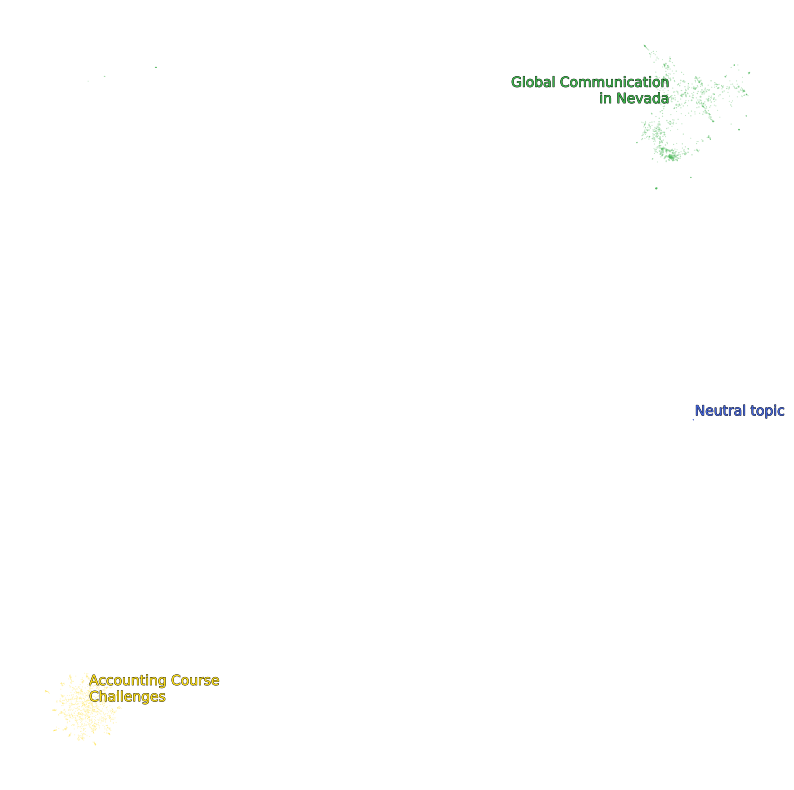

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [ ]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

NotImplementedError: ignored

In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] Converting notebook Topic_Modeling_with_Llama2.ipynb to markdown
[NbConvertApp] Support files will be in Topic_Modeling_with_Llama2_files/
[NbConvertApp] Making directory Topic_Modeling_with_Llama2_files
[NbConvertApp] Writing 13754635 bytes to Topic_Modeling_with_Llama2.md
